In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

> #### Using a specific frame from the image dataset that is closest to the average of all images, as determined by Mean Squared Error (MSE), helps reduce ghosting when compared to using the mean image itself. This happens because this specific image is a real image from the dataset, not a blend image like the mean image, so it matches the scene more closely. Subtracting this image from others removes background details more cleanly, highlighting actual changes in the scene without the strange overlapping images, or "ghosts," that can be visible when using the mean image.

#### Structural Similarity Index (SSIM)
>SSIM is designed to capture perceptual differences between images. SSIM considers luminance, contrast, and structure in its computation, providing a more human-eye aligned measure of similarity between images.

### Applied MSE and SSIM between mean image and all the images

In [4]:
# Load the data
data_scene = pd.read_hdf('scene.hdf5')

# Extract images
scene_images = np.stack(data_scene['image'].values)

# Calculate the mean image
mean_image = np.mean(scene_images, axis=0)

'''
For selecting the offset image from the scene image data measuring the MSE and SSIM

'''

# Compute MSE for each image in scene_images using mean_squared_error from sklearn
mse_values = [mean_squared_error(mean_image.ravel(), img.ravel()) for img in scene_images]

# Get indices of the 10 images closest to the mean image by MSE
closest_images_indices_mse = sorted(range(len(mse_values)), key=lambda k: mse_values[k])[:10]

# Print indices of closest images of mean
print("Closest images by MSE:", closest_images_indices_mse)

#Calculate SSIM for each image
ssim_values = [ssim(mean_image, img, data_range=img.max() - img.min()) for img in scene_images]

# Find the indices of the top 10 images with highest SSIM to the mean image
closest_images_indices_ssim = sorted(range(len(ssim_values)), key=lambda k: ssim_values[k], reverse=True)[:10]

print("Closest images by SSIM:", closest_images_indices_ssim)

#Taking offset based on the image indices measured from MSE and SSIM
offset = scene_images[171]
responsivity = 1
#Applying NUC

Closest images by MSE: [171, 172, 170, 40, 39, 41, 43, 42, 46, 47]
Closest images by SSIM: [172, 171, 42, 40, 170, 45, 47, 48, 43, 46]


(-0.5, 639.5, 479.5, -0.5)

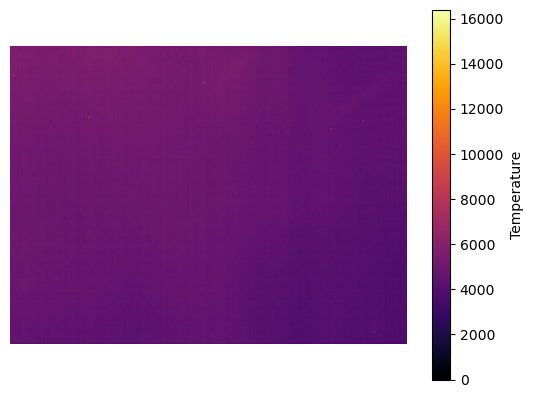

In [22]:
plt.figure()
img = plt.imshow(scene_images[250], cmap='inferno')
cbar = plt.colorbar(img)
# plt.title('Corrected Image')
cbar.set_label('Temperature')
plt.axis('off')


### Applying NUC

(-0.5, 639.5, 479.5, -0.5)

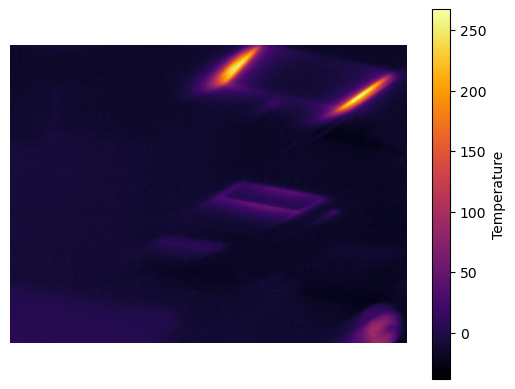

In [5]:
#Taking offset based on the image indices measured from MSE and SSIM
offset = scene_images[171]
responsivity = 1
# Correcting each scene image by applying NUC:
corrected_images = np.array([(image - offset)/responsivity for image in scene_images])

plt.figure()
img = plt.imshow(corrected_images[250], cmap='inferno')
cbar = plt.colorbar(img)
# plt.title('Corrected Image')
cbar.set_label('Temperature')
plt.axis('off')


In [24]:
corrected_images[250]

array([[-11., -15., -17., ..., -21., -18., -18.],
       [-15., -10., -12., ..., -14., -15.,  -6.],
       [-20., -15., -13., ..., -12., -17., -21.],
       ...,
       [  0.,   4.,   2., ..., -17., -26., -20.],
       [  5.,   1.,   5., ..., -20., -20., -18.],
       [  5.,   5.,   2., ..., -22., -20., -23.]], dtype=float32)

# For sliding Images

In [5]:
from ipywidgets import interact, IntSlider

# Create an interactive widget to select and display images
def display_image(index):
    img = plt.imshow(corrected_images[index], cmap='gray')
    plt.title(f'Corrected Image {index}')
    plt.axis('off')
    cbar = plt.colorbar(img)
    cbar.set_label('Temperature (°C)')

interact(display_image, index=IntSlider(min=0, max=len(corrected_images)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

<function __main__.display_image(index)>

# For video

### Gray

In [46]:
import cv2
import numpy as np

print()
def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image) # finding the Nan values 
        mean_val = np.nanmean(image) # taking the mean of non-Nan vlaues
        image[nan_mask] = mean_val # replacing with the mean of non-Nan values
    return image

# new sequences by clearing the Nan values
corrected_image_sequences_N = [replace_nans(image) for image in corrected_images]


def create_video_from_images(corrected_image_sequences_N, output_filename='task_3_S_3_171.avi', fps=40):

    # Normalize images based on global min and max
    global_min_n = min(image.min() for image in corrected_image_sequences_N)
    global_max_n = max(image.max() for image in corrected_image_sequences_N)
    corrected_image_sequences_N = [(255 * (image - global_min_n) / (global_max_n - global_min_n)).astype(np.uint8) for image in corrected_image_sequences_N]

    # Get the size of the images
    height, width = corrected_image_sequences_N[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=False)
    
    for image in corrected_image_sequences_N:
        out.write(image)
    
    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)

# With False Color

In [21]:
import cv2
import numpy as np

def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image)  # Finding the NaN values
        mean_val = np.nanmean(image)  # Taking the mean of non-NaN values
        image[nan_mask] = mean_val  # Replacing with the mean of non-NaN values
    return image

corrected_image_sequences_N = [replace_nans(image) for image in corrected_images]

def create_video_from_images(images, output_filename='task_3_S_3_JET.avi', fps=40):
    images_colored = []
    for image in images:
        # Normalize the image
        min_val = image.min()
        max_val = image.max()
        if max_val > min_val:
            normalized_image = (image - min_val) / (max_val - min_val)
        else:  # Avoid division by zero if all values are the same
            normalized_image = np.zeros_like(image)

        normalized_image = (255 * normalized_image).astype(np.uint8)  # Scale to 255 and convert to uint8

        # Apply COLORMAP_JET to the normalized image
        colored_image = cv2.applyColorMap(normalized_image, cv2.COLORMAP_JET)

        images_colored.append(colored_image)

    # Get the size of the images
    height, width = images_colored[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object with color
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=True)
    
    for image in images_colored:
        out.write(image)  # Write each frame to the video
    
    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)


# For Inferno

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Importing matplotlib for colormaps

def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image)  # Finding the NaN values 
        mean_val = np.nanmean(image)  # Taking the mean of non-NaN values
        image[nan_mask] = mean_val  # Replacing with the mean of non-NaN values
    return image

# Assuming 'corrected_images' is your input list of images
corrected_image_sequences_N = [replace_nans(image) for image in corrected_images]

def create_video_from_images(images, output_filename='task_3_S_1_inf.avi', fps=40):
    images_colored = []

    # Compute global min and max for consistent normalization
    global_min = np.min([image.min() for image in images])
    global_max = np.max([image.max() for image in images])

    for image in images:
        # Normalize the image with global min and max
        if global_max > global_min:  # Normal case
            normalized_image = (image - global_min) / (global_max - global_min)
        else:  # Avoid division by zero if all values are the same
            normalized_image = np.zeros_like(image)

        # Apply the 'inferno' colormap from matplotlib
        colored_image = plt.cm.inferno(normalized_image)
        images_colored.append((255 * colored_image[:, :, :3]).astype(np.uint8))  # Discard the alpha channel and convert to uint8

    # Get the size of the images
    height, width = images_colored[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object with color
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=True)
    
    for image in images_colored:
        out.write(image)  # Write each frame to the video
    
    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Importing matplotlib for colormaps

def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image)  # Finding the NaN values 
        mean_val = np.nanmean(image)  # Taking the mean of non-NaN values
        image[nan_mask] = mean_val  # Replacing with the mean of non-NaN values
    return image

# Assuming 'corrected_images' is your input list of images
corrected_image_sequences_N = [replace_nans(image) for image in corrected_images]

def create_video_from_images(images, output_filename='task_3_S_1_hot.avi', fps=40):
    images_colored = []
    for image in images:
        min_val = image.min()
        max_val = image.max()
        if max_val > min_val:  # Normal case
            normalized_image = (image - min_val) / (max_val - min_val)
        else:  # Avoid division by zero if all values are the same
            normalized_image = np.zeros_like(image)
        colored_image = plt.cm.inferno(normalized_image)
        images_colored.append((255 * colored_image[:, :, :3]).astype(np.uint8))  # Discard the alpha channel and convert to uint8

    # Get the size of the images
    height, width = images_colored[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object with color
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=True)
    
    for image in images_colored:
        out.write(image)  # Write each frame to the video
    
    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)


### For Signal to noise Ratio

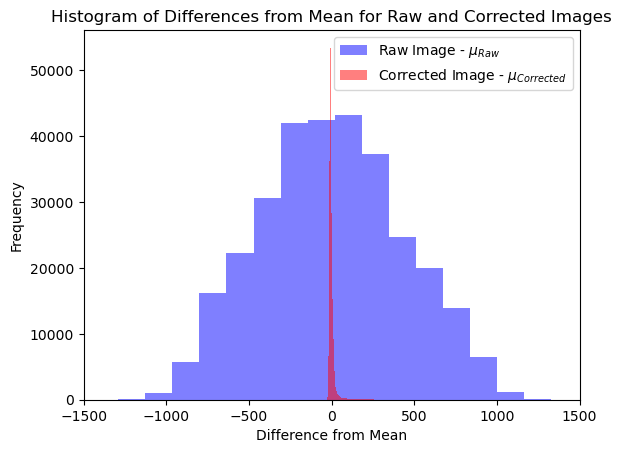

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

selected_index = 250
raw_image = scene_images[selected_index]
corrected_image = corrected_images[selected_index]

# Calculate the differences from the mean for each image
raw_diff = raw_image - np.mean(raw_image)
corrected_diff = corrected_image - np.mean(corrected_image)

# Plot histograms
plt.figure()
plt.hist(raw_diff.ravel(), bins=100, alpha=0.5, color='blue', label=r'Raw Image - $\mu_{Raw}$')
plt.hist(corrected_diff.ravel(), bins=100, alpha=0.5, color='red', label=r'Corrected Image - $\mu_{Corrected}$')

plt.xlabel('Difference from Mean')
plt.ylabel('Frequency')
plt.title('Histogram of Differences from Mean for Raw and Corrected Images')
plt.legend()
plt.xlim(-1500, 1500)
plt.show()
